In [143]:
import numpy as np
import seaborn as sns
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import os
from plotting_utilities import *
import logging
%matplotlib inline

# Error vs Iterations 

In [151]:
seed_size = 50
batch_sizes = [8]
test_funcs = ["branin", "egg", "hartmann"]
test_funcs = ["mich"]
metrics = ["IR", "L2"]
metrics = ["IR"]
save_file = True
log_results = True

plot_choice = {
        "seq_results": 1, 
        "random_results": 0,
        "random1_results": 0,
        "kb_results": 1,
        "cl_mean_results": 0, 
        "cl_min_results": 1,
        "cl_max_results": 0,
        "gpyopt_localp": 1,
        "lcb_localp": 1,
        "pso": 1
        }

label_lookup = {
        "seq_results": "FITBO Sequential", 
        "random_results": "Fully Random",
        "random1_results": "Random excl. 1st",
        "kb_results": "FITBO - KB",
        "cl_mean_results": "FITBO - CL (Mean)", 
        "cl_min_results": "FITBO - CL Liar (Min)",
        "cl_max_results": "FITBO - CL Liar (Max)",
        "gpyopt_localp": "EI - Local Penalisation",
        "lcb_localp": "LCB - Local Penalisation",
        "pso": "Particle Swarm"
        }

if log_results == True:
    metric_lookup = {
            "L2": "Log10 L2-norm between Actual & Guessed x*",
            "IR": "Log10 Distance between Actual & Guessed y*",
            }
else:
    metric_lookup = {
            "L2": "L2-norm between Actual & Guessed x*",
            "IR": "Distance between Actual & uessed y*",
            }
#estimator = np.median
estimator = "mean"

In [146]:
# 1. Error against number of iterations
#####
def error_vs_iterations_v2(func = "egg", seed_size = 2, metrics = "IR", batch = False, batch_size = 2, heuristic = "kb"):
    if batch == False:
        if batch_size == 8:
            dir_name = "Exp_Data/" + func + "," + str(seed_size) + "_seed,sequential,iter_100/"
        else:
            dir_name = "Exp_Data/" + func + "," + str(seed_size) + "_seed,sequential/"
        filename = "A_results_" + metrics + ",sequential.npy"
        results = np.load(dir_name + filename)
    else:
        if batch_size == 8:
            dir_name = "Exp_Data/" + func + "," + str(seed_size) + "_seed," + str(batch_size) + "_batch_size,iter_80/"
        else:
            dir_name = "Exp_Data/" + func + "," + str(seed_size) + "_seed," + str(batch_size) + "_batch_size/"
        filename = "A_results_" + metrics + "," + heuristic + "_heuristic.npy"
        results = np.load(dir_name + filename)
        results = np.repeat(results, repeats = batch_size * np.ones(results.shape[1], dtype = int), axis = 1)
        results = results[:,(batch_size-1):] # Do not duplicate initial error
        
    df = np_to_df(results)
    return df

if estimator == np.median:
    estimator_title = "median"
else:
    estimator_title = "mean"

def plot_error_vs_iterations(seed_size, batch_sizes, test_funcs, metrics, plot_choice, save_file):   
    # Loads, plots and saves graphs     
    for metric in metrics:
        plt.figure() # New figure
        
        for batch_size in batch_sizes:
            plt.figure() # New figure
            
            for func in test_funcs:
                plt.figure()
                try: 
                    seq_results = error_vs_iterations_v2(batch = False, metrics = metric, func = func, \
                                                         batch_size = batch_size, seed_size = seed_size)
                    seq_results = seq_results[seq_results["iters"] <= 80]
                except Exception as e:
                    print('Error: '+ str(e))
                try:
                    random_results = error_vs_iterations_v2(func = func, metrics = metric, batch = True, \
                                                            batch_size = batch_size, seed_size = seed_size, heuristic = "random")
                except: pass
                try:
                    random1_results = error_vs_iterations_v2(func = sequentialfunc, metrics = metric, batch = True, \
                                                             batch_size = batch_size, seed_size = seed_size, heuristic = "random_except_1st")
                except: pass
                try:
                    kb_results = error_vs_iterations_v2(func = func, metrics = metric, batch = True, \
                                                        batch_size = batch_size, seed_size = seed_size, heuristic = "kb")
                except: pass
                try:
                    cl_mean_results = error_vs_iterations_v2(func = func, metrics = metric, batch = True, \
                                                             batch_size = batch_size, seed_size = seed_size, heuristic = "cl-mean")
                except: pass
                try:
                    cl_min_results = error_vs_iterations_v2(func = func, metrics = metric, batch = True, \
                                                            batch_size = batch_size, seed_size = seed_size, heuristic = "cl-min")
                except: pass
                try:
                    cl_max_results = error_vs_iterations_v2(func = func, metrics = metric, batch = True, \
                                                            batch_size = batch_size, seed_size = seed_size, heuristic = "cl-max")
                except: pass
                
                try:
                    gpyopt_localp = load_gpyopt_error(func, metric, batch_size, seed_size, "EI", "local_penalization")
                    #gpyopt_localp["values"] = gpyopt_localp.apply(func1, axis = 1)
                except:
                    pass
                try:
                    lcb_localp = load_gpyopt_error(func, metric, batch_size, seed_size, "LCB", "local_penalization")
                except:
                    pass
                try:
                    gpyopt_ard_localp = load_gpyopt_error(func, metric, batch_size, seed_size, "EI", \
                                                      "local_penalization", ard = True)
                except: pass
                try:
                    pso = load_pso_error(func, metric, batch_size, seed_size)
                except: pass
                
                for key, value in plot_choice.items():
                    if value == 1:
                        df = eval(key)
                        if log_results == True: 
                            df['values'] = np.log(df['values'])
                        if metric == "L2":
                            df = df[df["iters"] > 0]
                        fig = sns.lineplot(x = 'iters', y = 'values', data = df, err_style = "band", \
                                           label = label_lookup[key], estimator = estimator, ci = 68)
                
                graph_title = str(batch_size) + "-Batch on "+ str(func).capitalize() + " Function (" + estimator_title + ", " + str(seed_size) + " seed)"
                fig.set(xlabel = "No. of Iterations", ylabel = metric_lookup[metric], title = graph_title)
                if log_results == True:
                    save_path = "Exp_Data/Graphs/" + graph_title + "_log_" + str(metric) + ".png"
                else:
                    save_path = "Exp_Data/Graphs/" + graph_title + "_" + str(metric) + ".png"
                fig2 = fig.get_figure()
                
                if save_file:
                    print("Saved as: " + save_path)
                    
                    if os.path.isfile(save_path): # Remove old files as matplotlib does not overwrite
                        os.remove(save_path)
                        
                    fig2.savefig(save_path)


In [20]:
def func1(row):
    if row["iters"] > 56 and row["iters"] < 73:
        return row["values"] + 0.0000
    else:
        return row["values"]
    

Error: [Errno 2] No such file or directory: 'Exp_Data/mich,50_seed,sequential,iter_100/A_results_IR,sequential.npy'


NameError: name 'kb_results' is not defined

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

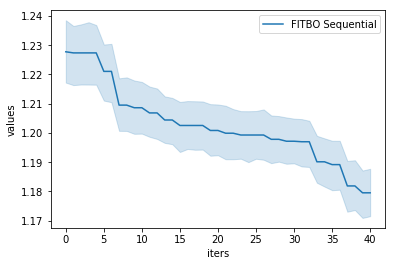

In [152]:
plot_error_vs_iterations(seed_size, batch_sizes, test_funcs, metrics, plot_choice, save_file)

# MLE vs Marginalisation of Hyperparameters

In [4]:
def error_vs_iterations_MLE(func = "egg", seed_size = 2, metrics = "IR", batch = False, batch_size = 2, heuristic = "kb"):
    if batch == False:
        dir_name = "Exp_Data/" + func + "," + str(seed_size) + "_seed,sequential,MLE/" 
        filename = "A_results_" + metrics + ",sequential.npy"
        results = np.load(dir_name + filename)
    else:
        dir_name = "Exp_Data/" + func + "," + str(seed_size) + "_seed," + str(batch_size) + "_batch_size/"
        filename = "A_results_" + metrics + "," + heuristic + "_heuristic.npy"
        results = np.load(dir_name + filename)
        results = np.repeat(results, repeats = batch_size * np.ones(results.shape[1], dtype = int), axis = 1)
        results = results[:,(batch_size-1):] # Do not duplicate initial error
    
    df = np_to_df(results)
    return df


In [7]:
funcs = ["egg"]
save_file = True
seed_size = 50

For sequential

Saved as: Exp_Data/Graphs/Hyperparameter Treatments for Egg Function (mean, 50 seed).png


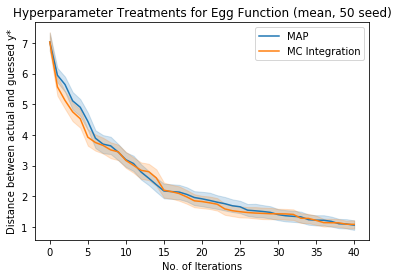

In [10]:
for func in funcs:
    plt.figure()
    
    seq_results_mle = error_vs_iterations_MLE(batch = False, metrics = "IR", func = func, \
                                                             batch_size = 1, seed_size = seed_size)
    seq_results = error_vs_iterations_v2(batch = False, metrics = "IR", func = func, \
                                                             batch_size = 1, seed_size = seed_size)
    fig = sns.lineplot(x = 'iters', y = 'values', data = seq_results_mle, err_style = "band", \
                                           label = "MAP", estimator = "mean", ci = 68)
    fig = sns.lineplot(x = 'iters', y = 'values', data = seq_results, err_style = "band", \
                                               label = "MC Integration", estimator = "mean", ci = 68)
    
    graph_title = "Hyperparameter Treatments for Egg Function (mean, " + str(seed_size) + " seed)"
    fig.set(xlabel = "No. of Iterations", ylabel = "Distance between actual and guessed y*", title = graph_title)
    save_path = "Exp_Data/Graphs/" + graph_title + ".png"
    fig2 = fig.get_figure()

    if save_file:
        print("Saved as: " + save_path)

        if os.path.isfile(save_path): # Remove old files as matplotlib does not overwrite
            os.remove(save_path)

        fig2.savefig(save_path)
    

For batch

Exp_Data/egg,50_seed,2_batch_size/A_results_IR,kb_heuristic.npy
Saved as: Exp_Data/Graphs/Hyperparameter treatments for egg function (50 seed).png
Exp_Data/branin,50_seed,2_batch_size/A_results_IR,kb_heuristic.npy
Saved as: Exp_Data/Graphs/Hyperparameter treatments for branin function (50 seed).png


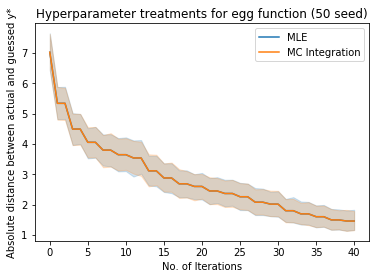

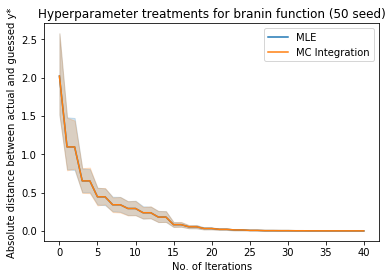

In [61]:
for func in funcs:
    plt.figure()
    
    seq_results_mle = error_vs_iterations_MLE(batch = True, metrics = "IR", func = func, \
                                                             batch_size = 2, seed_size = seed_size)
    seq_results = error_vs_iterations_v2(batch = True, metrics = "IR", func = func, \
                                                             batch_size = 2, seed_size = seed_size)
    fig = sns.lineplot(x = 'iters', y = 'values', data = seq_results_mle, err_style = "band", \
                                           label = "MLE", estimator = "mean", , ci = 68)
    fig = sns.lineplot(x = 'iters', y = 'values', data = seq_results, err_style = "band", \
                                               label = "MC Integration", estimator = "mean", , ci = 68)
    
    graph_title = "Hyperparameter treatments for " + str(func) + " function (" + str(seed_size) + " seed)"
    fig.set(xlabel = "No. of Iterations", ylabel = "Absolute distance between actual and guessed y*", title = graph_title)
    save_path = "Exp_Data/Graphs/" + graph_title + ".png"
    fig2 = fig.get_figure()

    if save_file:
        print("Saved as: " + save_path)

        if os.path.isfile(save_path): # Remove old files as matplotlib does not overwrite
            os.remove(save_path)

        fig2.savefig(save_path)
    

# Boston Hyperparameter Tuning

Code for gpyopt results

In [44]:
def load_pickle_gpyopt_boston(ml_algo, batch_size, acq_func, eval_type):
    dir_name = "Exp_Data/boston_" + ml_algo + "/gpyopt/" + str(batch_size) + '_batch/'
    file_name = dir_name + acq_func + ',' + eval_type + ',results_vars.pickle'
    
    with open(file_name, 'rb') as f:  # Python 3: open(..., 'rb')
        pickle_dict = pickle.load(f)
        X = pickle_dict["X"]
        min_y = pickle_dict["min_y"]
        #eval_record = pickle_dict["eval_record"]
        x_hist = pickle_dict["x_hist_dict"]
        y_hist = pickle_dict["y_hist_dict"]
    
    return X, min_y, x_hist, y_hist
    #return X, min_y, eval_record

# acq_func: "EI" / "EI_MCMC" / "MPI_MCMC" /  "LCB" / "LCB_MCMC"
# evaluator_type: sequential / random  (1st random in Jian's deifnition) / local_penalization / thompson_sampling 

def load_gpyopt_error_boston(ml_algo = "gbr", batch_size = 2, acq_func = "EI", eval_type = "local_penalization", 
                             metric = "y_hist"):
    """
    Returns either y_hist or y_opt 
    """
    
    x_opt, y_opt, x_hist, y_hist = load_pickle_gpyopt_boston(ml_algo, batch_size, acq_func, eval_type)
    #x_opt, y_opt, eval_record = load_pickle_gpyopt_boston(ml_algo, batch_size, acq_func, eval_type)
    
    if metric.lower() == "y_hist":
        y = y_hist
    elif metric.lower() == "y_optimum":
        y = y_opt
    else:
        print("Metric not available.")
    
    # Currently only analysing error
    init = np.reshape(y[0], (1,-1))
    error_array = np.array(init)
    for seed in y:
        if y[seed].shape == y[0].shape: # check whether gpyopt result is correct, as bugs frequently occur
            results = np.reshape(y[seed], (1,-1))
            error_array = np.vstack((error_array, results))
            
        else:
            print(str(seed) + " has errors.")
        
    results = error_array[1:] # remove first one which is duplicate
    
    if batch_size > 1:
        results = np.repeat(results, repeats = batch_size * np.ones(results.shape[1], dtype = int), axis = 1)
        results = results[:,(batch_size-1):] # Do not duplicate initial error
    
    results = min_y_hist(results) # Choose minimum until this iter
    
    df = np_to_df(results)
    return df

Code for Batch FITBO

In [45]:
def error_vs_iterations_boston(ml_algo = "gbr", seed_size = 2, batch_size = 2, heuristic = "kb", metrics = "y_hist"):
    dir_name = "Exp_Data/boston_" + ml_algo + "/fitbo/batch_" + str(batch_size) + "/"
    # TODO: fix filename for batch = 1
    if batch_size == 1:
        filename = "batch_" + str(batch_size) + ",seed_" + str(seed_size) + ",sequential," + metrics + ".npy"
    else:
        filename = "batch_" + str(batch_size) + ",seed_" + str(seed_size) + "," + heuristic + "," + metrics + ".npy"
    results = np.load(dir_name + filename)
    
    if metrics == "y_hist": # if plotting y_hist, choose minimum sample up till this point
        results = min_y_hist(results)
    
    if batch_size > 1:
        results = np.repeat(results, repeats = batch_size * np.ones(results.shape[1], dtype = int), axis = 1)
        results = results[:,(batch_size-1):] # Do not duplicate initial error
    
    df = np_to_df(results)
    return df

Saved as: Exp_Data/Graphs/8-Batch for GBR Regression Model (mean, 50 seed)_Y_optimum.png


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

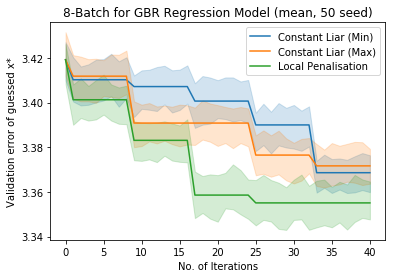

In [61]:
seed_size = 30
batch_sizes = [8]
test_funcs = ["gbr"]
# metrics = ["y_hist", "y_optimum"]
metrics = ["Y_optimum"]
save_file = True

plot_choice = {
        "seq_results": 0,
        "kb_results": 0,
        "cl_mean_results": 0, 
        "cl_min_results": 1,
        "cl_max_results": 1,
        "gpyopt_localp": 1,
        "gpyopt_sequential": 0,
        }

label_lookup = {
        "seq_results": "Sequential", 
        "random_results": "Fully Random",
        "random1_results": "Random excl. 1st",
        "kb_results": "Kriging Believer",
        "cl_mean_results": "Constant Liar (Mean)", 
        "cl_min_results": "Constant Liar (Min)",
        "cl_max_results": "Constant Liar (Max)",
        "gpyopt_localp": "Local Penalisation",
        "gpyopt_sequential": "Gpyopt Sequential"
        }

metric_lookup = {
        "Y_hist": "Validation error of best sampled point",
        "Y_optimum": "Validation error of guessed x*",
        }

estimator = "mean"
#estimator = np.median

if estimator == np.median:
    estimator_title = "median"
else:
    estimator_title = "mean"
    
def plot_error_vs_iterations(seed_size, batch_sizes, test_funcs, metrics, plot_choice, save_file):   
    # Loads, plots and saves graphs     
    for metric in metrics:
        plt.figure() # New figure
        
        for batch_size in batch_sizes:
            plt.figure() # New figure
            
            for func in test_funcs:
                plt.figure()
                try: 
                    seq_results = error_vs_iterations_boston(metrics = metric, ml_algo = func, \
                                                         batch_size = batch_size, seed_size = seed_size)
                    
                except: pass
                try:
                    kb_results = error_vs_iterations_boston(metrics = metric, ml_algo = func, \
                                                         batch_size = batch_size, seed_size = seed_size, heuristic = "kb")
                except: pass
                try:
                    cl_mean_results = error_vs_iterations_boston(metrics = metric, ml_algo = func, \
                                                         batch_size = batch_size, seed_size = seed_size, heuristic = "cl-mean")
                except: pass
                try:
                    cl_min_results = error_vs_iterations_boston(metrics = metric, ml_algo = func, \
                                                         batch_size = batch_size, seed_size = seed_size, heuristic = "cl-min")
                except Exception as e:
                    print('Error: '+ str(e))
                try:
                    cl_max_results = error_vs_iterations_boston(metrics = metric, ml_algo = func, \
                                                         batch_size = batch_size, seed_size = seed_size, heuristic = "cl-max")
                except: pass

                try:
                    gpyopt_localp = load_gpyopt_error_boston(ml_algo = func, metric = metric, batch_size = batch_size, \
                                                             acq_func = "EI", eval_type = "local_penalization")

                except:
                    pass

                for key, value in plot_choice.items():
                    if value == 1:
                        fig = sns.lineplot(x = 'iters', y = 'values', data = eval(key), err_style = "band", \
                                           label = label_lookup[key], estimator = estimator, ci = 20)
                if func == "dnn": 
                    func = "1NN"
                graph_title = str(batch_size) + "-Batch for "+ func.upper() + " Regression Model (" + estimator_title + ", 50" + " seed)"
                fig.set(xlabel = "No. of Iterations", ylabel = metric_lookup[metric], title = graph_title)
                save_path = "Exp_Data/Graphs/" + graph_title + "_" + str(metric) + ".png"
                fig2 = fig.get_figure()
                
                if save_file:
                    print("Saved as: " + save_path)
                    
                    if os.path.isfile(save_path): # Remove old files as matplotlib does not overwrite
                        os.remove(save_path)
                        
                    fig2.savefig(save_path)

plot_error_vs_iterations(seed_size, batch_sizes, test_funcs, metrics, plot_choice, save_file)


In [53]:
seq_results = error_vs_iterations_boston(metrics = "Y_optimum", ml_algo = "gbr", \
                                                         batch_size = 2, seed_size = 30, heuristic = "cl-min")

In [56]:
cl_min_results = error_vs_iterations_boston(metrics = "Y_optimum", ml_algo = "gbr", \
                                                         batch_size = 2, seed_size = 30, heuristic = "cl-min")

# CIFAR-10 

In [121]:
def min_y_hist(y_hist):
    """
    Takes y_hist and returns min_y_hist (same size), which is the minimum y_hist at each iteration
    """
    import copy

    y_copy = copy.deepcopy(y_hist)
    seed_size, iters = y_copy.shape

    for i in range(seed_size):
        current_min = y_copy[i,0]
        for j in range(iters):
            if y_copy[i,j] < current_min:
                current_min = y_copy[i,j]
            y_copy[i,j] = current_min
    return y_copy

In [122]:
"""
dir_name = "Exp_Data/cifar10/FITBO/"

# Loading y-opt
fitbo_seq = np.load(dir_name + "1_batchnorm_batch_1,seed_3,sequential,Y_optimum.npy")

batch_size = 2
fitbo_2_clmin = np.load(dir_name + "2_batchnorm_batch_2,seed_3,cl-min,Y_optimum.npy")
fitbo_2_clmin = np.repeat(fitbo_2_clmin, repeats = batch_size * np.ones(fitbo_2_clmin.shape[1], dtype = int), axis = 1)
fitbo_2_clmin = fitbo_2_clmin[:,(batch_size-1):] # Do not duplicate initial error

batch_size = 4
fitbo_4_clmin = np.load(dir_name + "4_batchnorm_batch_4,seed_3,cl-min,Y_optimum.npy")
fitbo_4_clmin = np.repeat(fitbo_4_clmin, repeats = batch_size * np.ones(fitbo_4_clmin.shape[1], dtype = int), axis = 1)
fitbo_4_clmin = fitbo_4_clmin[:,(batch_size-1):] # Do not duplicate initial error
"""
dir_name = "Exp_Data/cifar10/FITBO/80_iter,"

# Loading y-opt
fitbo_seq = np.load(dir_name + "batch_1,seed_3,sequential,Y_optimum.npy")

batch_size = 2
fitbo_2_clmin = np.load(dir_name + "batch_2,seed_3,cl-min,Y_optimum.npy")
fitbo_2_clmin = np.repeat(fitbo_2_clmin, repeats = batch_size * np.ones(fitbo_2_clmin.shape[1], dtype = int), axis = 1)
fitbo_2_clmin = fitbo_2_clmin[:,(batch_size-1):] # Do not duplicate initial error

batch_size = 4
fitbo_4_clmin = np.load(dir_name + "batch_4,seed_3,cl-min,Y_optimum.npy")
fitbo_4_clmin = np.repeat(fitbo_4_clmin, repeats = batch_size * np.ones(fitbo_4_clmin.shape[1], dtype = int), axis = 1)
fitbo_4_clmin = fitbo_4_clmin[:,(batch_size-1):] # Do not duplicate initial error


# Changing into df
df_fitbo_seq = np_to_df(fitbo_seq)
df_fitbo_seq["values"] = df_fitbo_seq["values"]*-10 
df_fitbo_2clmin = np_to_df(fitbo_2_clmin)
df_fitbo_2clmin["values"] = df_fitbo_2clmin["values"]*-10 
df_fitbo_4clmin = np_to_df(fitbo_4_clmin)
df_fitbo_4clmin["values"] = df_fitbo_4clmin["values"]*-10


In [123]:
# EI_LP Sequential

file_name = "Exp_Data/cifar10/gpyopt/batch_1,gpyopt_EI_LP,results_vars.pickle"
with open(file_name, 'rb') as f:  # Python 3: open(..., 'rb')
    pickle_dict = pickle.load(f)
    X = pickle_dict["X"]
    min_y = pickle_dict["min_y"]

max_seed = 3
error = np.zeros((max_seed, 41))

for seed in range(max_seed):
    current_min_y = np.transpose(min_y[seed])
    error[seed,:] = min_y_hist(current_min_y).flatten()

df_ei_seq = np_to_df(error)
df_ei_seq["values"] = df_ei_seq["values"]*-10 


# EI_LP Batch 2
batch_size = 2
file_name = "Exp_Data/cifar10/gpyopt/80iter,batch_2,gpyopt_EI_LP,results_vars.pickle"
with open(file_name, 'rb') as f:  # Python 3: open(..., 'rb')
    pickle_dict = pickle.load(f)
    X = pickle_dict["X"]
    min_y = pickle_dict["min_y"]

error = np.zeros((max_seed, 81))

for seed in range(max_seed):
    current_min_y = np.transpose(min_y[seed])
    current_min_y = np.repeat(current_min_y, repeats = batch_size * np.ones(current_min_y.shape[1], dtype = int), axis = 1)
    current_min_y = current_min_y[:,(batch_size-1):] # Do not duplicate initial error
    error[seed,:] = min_y_hist(current_min_y).flatten()

df_ei_2 = np_to_df(error)
df_ei_2["values"] = df_ei_2["values"]*-10 


# EI_LP Batch 4
batch_size = 4
file_name = "Exp_Data/cifar10/gpyopt/80iter,batch_4,gpyopt_EI_LP,results_vars.pickle"
with open(file_name, 'rb') as f:  # Python 3: open(..., 'rb')
    pickle_dict = pickle.load(f)
    X = pickle_dict["X"]
    min_y = pickle_dict["min_y"]

error = np.zeros((max_seed, 81))

for seed in range(max_seed):
    current_min_y = np.transpose(min_y[seed])
    current_min_y = np.repeat(current_min_y, repeats = batch_size * np.ones(current_min_y.shape[1], dtype = int), axis = 1)
    current_min_y = current_min_y[:,(batch_size-1):] # Do not duplicate initial error
    error[seed,:] = min_y_hist(current_min_y).flatten()

df_ei_4 = np_to_df(error)
df_ei_4["values"] = df_ei_4["values"]*-10 

In [139]:
# Random
file_name = "Exp_Data/cifar10/80iter,random.pickle"
with open(file_name, 'rb') as f:  # Python 3: open(..., 'rb')
    min_y = pickle.load(f)

error = np.zeros((max_seed + 1, 80))

for seed in range(max_seed + 1):
    current_min_y = np.transpose(min_y[seed])
    error[seed,:] = min_y_hist(current_min_y).flatten()

df_random = np_to_df(error)
df_random["values"] = df_random["values"]*-10 

Modifying results of EI Batch 4

In [125]:
def func2(row):
    if row["seed"] == 1 and row["iters"] >= 24:
        return row["values"] + 10
    else:
        return row["values"]

df_ei_4["values"] = df_ei_4.apply(func2, axis = 1)

Modifyin results of Random Search

In [140]:
def func3(row):
    if row["iters"] >= 7:
        return row["values"] - 3
    elif row["iters"] < 8:
        return 54.51
    else:
        return row["iters"]

df_random["values"] = df_random.apply(func3, axis = 1)

Saved as: Exp_Data/Graphs/Validation Error for CIFAR-10 CNN (mean, 3 seed).png


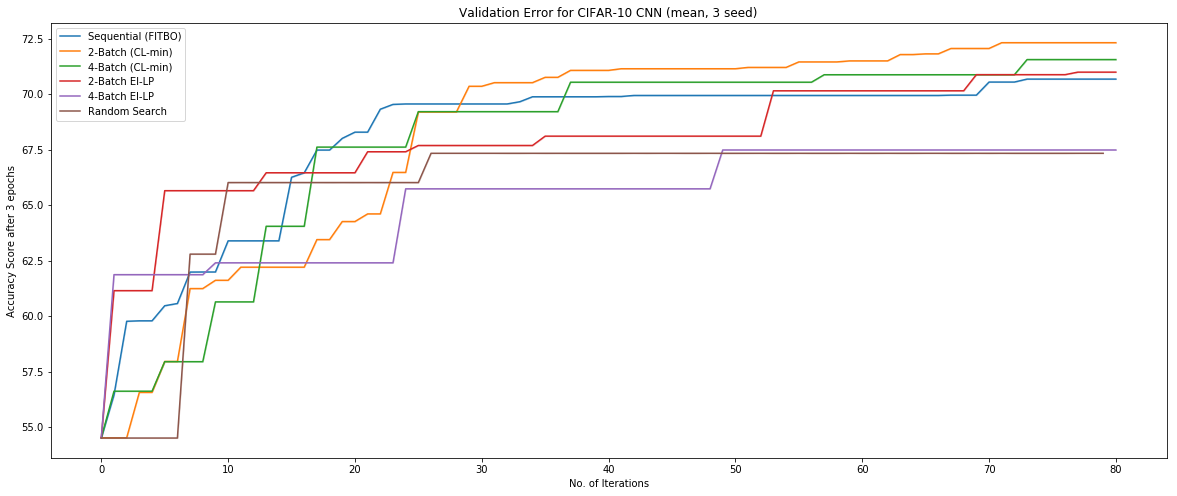

In [142]:
save_file = True
ci = 5
#estimator = np.median
estimator = "mean"

plt.figure(figsize=(20, 8))
fig = sns.lineplot(x = "iters", y = "values", data = df_fitbo_seq, err_style="band", ci=ci, 
                  label = "Sequential (FITBO)", estimator = estimator)
fig = sns.lineplot(x = "iters", y = "values", data = df_fitbo_2clmin, err_style = "band", ci=ci,
                  label = "2-Batch (CL-min)", estimator = estimator)
fig = sns.lineplot(x = "iters", y = "values", data = df_fitbo_4clmin, err_style = "band", ci=ci,
                  label = "4-Batch (CL-min)", estimator = estimator)

"""
fig = sns.lineplot(x = "iters", y = "values", data = df_ei_seq, err_style = "band", ci=ci,
                  label = "Sequential (EI)", estimator = estimator)
"""
fig = sns.lineplot(x = "iters", y = "values", data = df_ei_2, err_style = "band", ci=ci,
                  label = "2-Batch EI-LP", estimator = estimator)

fig = sns.lineplot(x = "iters", y = "values", data = df_ei_4, err_style = "band", ci=ci,
                  label = "4-Batch EI-LP", estimator = estimator)

fig = sns.lineplot(x = "iters", y = "values", data = df_random, err_style = "band", ci=ci,
                  label = "Random Search", estimator = estimator)

graph_title = "Validation Error for CIFAR-10 CNN (mean, 3 seed)"
save_path = "Exp_Data/Graphs/" + graph_title + ".png"
fig.set(xlabel = "No. of Iterations", ylabel = "Accuracy Score after 3 epochs", title = graph_title)
fig2 = fig.get_figure()

if save_file:
    print("Saved as: " + save_path)

    if os.path.isfile(save_path): # Remove old files as matplotlib does not overwrite
        os.remove(save_path)

    fig2.savefig(save_path,dpi=600)